# Project: WeRateDogs Analyzed

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#DR">Data Wrangling</a></li>
<li><a href="#DataAna">Data Analysis and Visualization</a></li>
</ul>

<a id='intro'></a> 
## Introduction

In this project, a collection of datasets from different sources is acquired, cleaned, assessed and finally analyzed. The datasets are all related to the WeRateDogs twitter data along with a collection of dog breed predictions. The project consists of the following sections:

- **Data Wrangling**
    - Collection
    - Assessment
    - Cleaning
 
 
- **Storing, Analyzing, and Visualizing the Wrangled Data**


- **Reporting:**
    1. The data wrangling efforts, and 
    2. The data analyses and visualizations

In [525]:
# import all required libraries
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import os
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

-----

<a id='DR'></a>
## Data Wrangling

### Data Collection

Data is available through the following sources:

1. The WeRateDogs Twitter archive `twitter-archive-enhanced.csv` which is provided by Udacity.
2. The tweet image predictions, i.e., what breed of dog (or another object, animal, etc.) is present in each tweet according to a neural network. This file (`image_predictions.tsv`) is hosted on Udacity's server's URL: https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv
3. Each tweet's retweet count, favorite count, and date/time of creation. This data will be collected using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called `tweet_json.txt file`. 

#### Step 1: Download (Manually) and Load `twitter_archive_enhanced.csv`

In [3]:
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


#### Step 2: Download (Using Code) and Load `image_predictions.tsv`

In [4]:
# Download (image_predictions.tsv) using the Requests library
filename ="image_predictions.tsv"
url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
if not os.path.exists(filename):
    with open(filename, mode = 'wb') as file:
        file.write(response.content)

In [5]:
# Load the image predictions file
df_image_pred = pd.read_csv('image_predictions.tsv', sep='\t')
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Step 3: Incquire and Build the Tweets Data

In [14]:
# Initiate a tweeter API
# These are hidden to comply with Twitter's API terms and conditions

consumer_key = 'XXXXX'
consumer_secret = 'XXXXX'
access_token = 'XXXXX'
access_secret = 'XXXXX'

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [ ]:
# get tweet id's from the twitter archive dataframe
tweet_ids = df_twitter_archive.tweet_id
print('total number of tweets = ' + str(len(tweet_ids)))
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
fails_dict = {}
count = 0
# Save each tweet's data as a new line in the file 'tweet_json.txt' with JSON format
with open('tweet_json.txt', 'w') as outfile:
    # loop over all the tweet id's
    for tweet_id in tweet_ids:
        count += 1
        try:
            # get tweet data
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            print(str(count) + "." + str(tweet_id) + ": Success")
            json.dump(tweet._json, outfile)
            outfile.write('\n')
        except tweepy.TweepError as e:
            print(str(count) + "." + str(tweet_id) + ": Fail")
            fails_dict[tweet_id] = e
            pass

total number of tweets = 2356
1.892420643555336193: Success
2.892177421306343426: Success
3.891815181378084864: Success
4.891689557279858688: Success
5.891327558926688256: Success
6.891087950875897856: Success
7.890971913173991426: Success
8.890729181411237888: Success
9.890609185150312448: Success
10.890240255349198849: Success
11.890006608113172480: Success
12.889880896479866881: Success
13.889665388333682689: Success
14.889638837579907072: Success
15.889531135344209921: Success
16.889278841981685760: Success
17.888917238123831296: Success
18.888804989199671297: Success
19.888554962724278272: Success
20.888202515573088257: Fail
21.888078434458587136: Success
22.887705289381826560: Success
23.887517139158093824: Success
24.887473957103951883: Success
25.887343217045368832: Success
26.887101392804085760: Success
27.886983233522544640: Success
28.886736880519319552: Success
29.886680336477933568: Success
30.886366144734445568: Success
31.886267009285017600: Success
32.886258384151887873

262.842846295480000512: Success
263.842765311967449089: Success
264.842535590457499648: Success
265.842163532590374912: Success
266.842115215311396866: Success
267.841833993020538882: Success
268.841680585030541313: Success
269.841439858740625411: Success
270.841320156043304961: Success
271.841314665196081154: Success
272.841077006473256960: Success
273.840761248237133825: Success
274.840728873075638272: Success
275.840698636975636481: Success
276.840696689258311684: Success
277.840632337062862849: Success
278.840370681858686976: Success
279.840268004936019968: Success
280.839990271299457024: Success
281.839549326359670784: Success
282.839290600511926273: Success
283.839239871831150596: Success
284.838952994649550848: Success
285.838921590096166913: Success
286.838916489579200512: Success
287.838831947270979586: Success
288.838561493054533637: Success
289.838476387338051585: Success
290.838201503651401729: Success
291.838150277551247360: Success
292.838085839343206401: Success
293.8380

519.810657578271330305: Success
520.810284430598270976: Success
521.810254108431155201: Success
522.809920764300447744: Success
523.809808892968534016: Success
524.809448704142938112: Success
525.809220051211603969: Success
526.809084759137812480: Success
527.808838249661788160: Success
528.808733504066486276: Success
529.808501579447930884: Success
530.808344865868283904: Success
531.808134635716833280: Success
532.808106460588765185: Success
533.808001312164028416: Success
534.807621403335917568: Success
535.807106840509214720: Success
536.807059379405148160: Success
537.807010152071229440: Success
538.806629075125202948: Success
539.806620845233815552: Success
540.806576416489959424: Success
541.806542213899489280: Success
542.806242860592926720: Success
543.806219024703037440: Success
544.805958939288408065: Success
545.805932879469572096: Success
546.805826884734976000: Success
547.805823200554876929: Success
548.805520635690676224: Success
549.805487436403003392: Success
550.8052

777.776113305656188928: Success
778.776088319444877312: Success
779.775898661951791106: Success
780.775842724423557120: Success
781.775733305207554048: Success
782.775729183532220416: Success
783.775364825476165632: Success
784.775350846108426240: Success
785.775096608509886464: Fail
786.775085132600442880: Success
787.774757898236878852: Success
788.774639387460112384: Success
789.774314403806253056: Success
790.773985732834758656: Success
791.773922284943896577: Success
792.773704687002451968: Success
793.773670353721753600: Success
794.773547596996571136: Success
795.773336787167145985: Success
796.773308824254029826: Success
797.773247561583001600: Success
798.773191612633579521: Success
799.772877495989305348: Success
800.772826264096874500: Success
801.772615324260794368: Success
802.772581559778025472: Success
803.772193107915964416: Success
804.772152991789019136: Success
805.772117678702071809: Success
806.772114945936949249: Success
807.772102971039580160: Success
808.7719089

Rate limit reached. Sleeping for: 702


880.760641137271070720: Success
881.760539183865880579: Success
882.760521673607086080: Success
883.760290219849637889: Success
884.760252756032651264: Success
885.760190180481531904: Success
886.760153949710192640: Success
887.759943073749200896: Success
888.759923798737051648: Success
889.759846353224826880: Success
890.759793422261743616: Success
891.759566828574212096: Success
892.759557299618865152: Success
893.759447681597108224: Success
894.759446261539934208: Success
895.759197388317847553: Success
896.759159934323924993: Success
897.759099523532779520: Success
898.759047813560868866: Success
899.758854675097526272: Success
900.758828659922702336: Success
901.758740312047005698: Success
902.758474966123810816: Success
903.758467244762497024: Success
904.758405701903519748: Success
905.758355060040593408: Success
906.758099635764359168: Success
907.758041019896193024: Success
908.757741869644341248: Success
909.757729163776290825: Success
910.757725642876129280: Success
911.7576

1133.728760639972315136: Success
1134.728751179681943552: Success
1135.728653952833728512: Success
1136.728409960103686147: Success
1137.728387165835677696: Success
1138.728046963732717569: Success
1139.728035342121635841: Success
1140.728015554473250816: Success
1141.727685679342333952: Success
1142.727644517743104000: Success
1143.727524757080539137: Success
1144.727314416056803329: Success
1145.727286334147182592: Success
1146.727175381690781696: Success
1147.727155742655025152: Success
1148.726935089318363137: Success
1149.726887082820554753: Success
1150.726828223124897792: Success
1151.726224900189511680: Success
1152.725842289046749185: Success
1153.725786712245440512: Success
1154.725729321944506368: Success
1155.725458796924002305: Success
1156.724983749226668032: Success
1157.724771698126512129: Success
1158.724405726123311104: Success
1159.724049859469295616: Success
1160.724046343203856385: Success
1161.724004602748780546: Success
1162.723912936180330496: Success
1163.72368

1383.700864154249383937: Success
1384.700847567345688576: Success
1385.700796979434098688: Success
1386.700747788515020802: Success
1387.700518061187723268: Success
1388.700505138482569216: Success
1389.700462010979500032: Success
1390.700167517596164096: Success
1391.700151421916807169: Success
1392.700143752053182464: Success
1393.700062718104104960: Success
1394.700029284593901568: Success
1395.700002074055016451: Success
1396.699801817392291840: Success
1397.699788877217865730: Success
1398.699779630832685056: Success
1399.699775878809702401: Success
1400.699691744225525762: Success
1401.699446877801091073: Success
1402.699434518667751424: Success
1403.699423671849451520: Success
1404.699413908797464576: Success
1405.699370870310113280: Success
1406.699323444782047232: Success
1407.699088579889332224: Success
1408.699079609774645248: Success
1409.699072405256409088: Success
1410.699060279947165696: Success
1411.699036661657767936: Success
1412.698989035503689728: Success
1413.69895

1632.684481074559381504: Success
1633.684460069371654144: Success
1634.684241637099323392: Success
1635.684225744407494656: Success
1636.684222868335505415: Success
1637.684200372118904832: Success
1638.684195085588783105: Success
1639.684188786104872960: Success
1640.684177701129875456: Success
1641.684147889187209216: Success
1642.684122891630342144: Success
1643.684097758874210310: Success
1644.683857920510050305: Success
1645.683852578183077888: Success
1646.683849932751646720: Success
1647.683834909291606017: Success
1648.683828599284170753: Success
1649.683773439333797890: Success
1650.683742671509258241: Success
1651.683515932363329536: Success
1652.683498322573824003: Success
1653.683481228088049664: Success
1654.683462770029932544: Success
1655.683449695444799489: Success
1656.683391852557561860: Success
1657.683357973142474752: Success
1658.683142553609318400: Success
1659.683111407806746624: Success
1660.683098815881154561: Success
1661.683078886620553216: Success
1662.68303

Rate limit reached. Sleeping for: 720


1780.677716515794329600: Success


In [230]:
tweet_dict_list = []
count = 0
# open the JSON file and loop line by line to acquire the tweet data (id, time stamp, retweet count, favorite count)
with open('tweet-json.txt', encoding='utf-8') as file:
    for line in file:
        count += 1
        tweet = json.loads(line)
        #print(count)
        tweet_id = tweet['id']
        timestamp = tweet['created_at']
        retweet_count = tweet['retweet_count']
        favorite_count = tweet['favorite_count']
        try:
            image_url = tweet['entities']['media'][0]['media_url_https']
        except:
            image_url = np.nan
        # Append to list of dictionaries
        tweet_dict_list.append({'tweet_id': tweet_id,
                                'timestamp': timestamp,
                                'retweet_count': retweet_count,
                                'favorite_count': favorite_count,
                                'image_url': image_url})
# build the dataframe
df_tweet_data = pd.DataFrame(tweet_dict_list, columns = ['tweet_id', 'timestamp', 'retweet_count', 'favorite_count', 'image_url'])
df_tweet_data.head()

,tweet_id,timestamp,retweet_count,favorite_count,image_url
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9774,41048,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg


-----

### Data Assessment

Data is now available in three dataframes. Each dataframe is going to be assessed to identify any potential data quality or tidiness issues.

### `df_twitter_archive`:

In [402]:
# take a look into data
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [403]:
# take a look into data
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [404]:
# check for duplicated rows (expanded_urls)
df_twitter_archive.duplicated().sum()

0

In [405]:
# check for duplicated rows
df_twitter_archive.expanded_urls.duplicated().sum()

137

In [408]:
# there are 79 duplicated rows with equal expanded_urls to other rows
(df_twitter_archive.duplicated(subset=['expanded_urls']) & df_twitter_archive['expanded_urls'].notna()).sum()

79

In [406]:
# check for abnormal numerical data
df_twitter_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [407]:
# check url format
df_twitter_archive.expanded_urls[0]

'https://twitter.com/dog_rates/status/892420643555336193/photo/1'

In [524]:
# check dog names
df_twitter_archive[df_twitter_archive.name=="None"].text[7]

"When you watch your owner call another dog a good boy but then they turn back to you and say you're a great boy. 13/10 https://t.co/v0nONBcwxq"

#### Quality Issues

1. Multiple columns are almost empty
2. `expanded_url` column has missing data
3. Rating denominator has a zero value which makes the rating inf
4. Rating denominator is not always 10 (WeRateDogs has a trend of having the denominator = 10)
5. Some rating numerators has large values (1776) and has to be normalized
6. `timestamp` is shown as an object type not as a datetime type
7. There are 79 duplicated rows with repeated `expanded_urls` while different tweet_id

**Note:** This issue will affect the joining the dataframes since it will be based on the `tweet_id` and removing any `tweet_id` from a dataframe can result of losing a join key. Hence, this will be dealt with after joining the dataframes.

#### Tidiness Issues

1. This dataframe holds many fields that are not necessary for the aimed analysis. columns of interest are:
    - `tweet_id`
    - `timestamp`
    - `rating_numerator`
    - `rating_denominator`
    - `name`

### `df_image_pred`:

In [241]:
# take a look into data
df_image_pred.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,welsh_springer_spaniel,0.465074,True,collie,0.156665,True,shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,german_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,rottweiler,0.243682,True,doberman,0.154629,True


In [411]:
# take a look into data
df_image_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [412]:
# check for duplicates
df_image_pred.duplicated().sum()

0

In [413]:
# check for duplicates
df_image_pred.jpg_url.duplicated().sum()

66

In [414]:
# check for duplicates
df_image_pred.tweet_id.duplicated().sum()

0

In [415]:
# there are 66 duplicated rows with equal jpg_url to other rows
(df_image_pred.duplicated(subset=['jpg_url']) & df_image_pred['jpg_url'].notna()).sum()

66

In [416]:
# check numerical data for abnormalities
df_image_pred.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


#### Quality Issues

1. While the archive folder has 2356 observations, this dataframe has 2075 observations
2. There are 66 duplicated rows with repeated `jpg_url` while different tweet_id

**Note:** This issue will affect the joining the dataframes since it will be based on the `tweet_id` and removing any `tweet_id` from a dataframe can result of losing a join key. Hence, this will be dealt with after joining the dataframes.

#### Tidiness Issues

1. Dog breeds are not consistent in lower or upper case and has an underscore between the names


### `df_tweet_data`:

In [417]:
# take a look into data
df_tweet_data.head()

,tweet_id,timestamp,retweet_count,favorite_count,image_url
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9774,41048,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg


In [418]:
# take a look into data
df_tweet_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 5 columns):
tweet_id          2354 non-null int64
timestamp         2354 non-null object
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
image_url         2073 non-null object
dtypes: int64(3), object(2)
memory usage: 92.0+ KB


In [419]:
# check for duplicates
df_tweet_data.duplicated().any()

False

In [440]:
# there are 65 duplicated rows with equal jpg_url to other rows
(df_tweet_data.duplicated(subset=['image_url']) & df_tweet_data['image_url'].notna()).sum()

65

#### Quality Issues

1. While the archive dataframe has 2356 observations, the image prediction dataframe has 2075 observations, this dataframe has 2353 observations
2. There are missing `image_url` data
3. There are 65 duplicated rows with repeated `image_url` while different tweet_id

**Note:** This issue will affect the joining the dataframes since it will be based on the `tweet_id` and removing any `tweet_id` from a dataframe can result of losing a join key. Hence, this will be dealt with after joining the dataframes.

#### Tidiness Issues

1. `timestamp` data are in a single column. Month, day, weekday, and year is better placed in separate columns. 

### `All Dataframes`:

#### Tidiness Issues

1. tweet_id and image_url are repeated

-----

### Data Cleaning

Now it is time to clean the data by addressing the issues listed above which are summarized below.

-----

### `df_twitter_archive`:

In [443]:
# Make a copy of the dataframe
df_twitter_archive_clean = df_twitter_archive

### Quality Issue 1:
#### Define: 
Multiple columns are almost empty
#### Code:
Drop the columns which are almost empty (with more than 2000 empty cells)

In [444]:
# get the list of columns with more than 2000 nan values to drop and drop them
max_number_of_nas = 2000
df_twitter_archive_clean = df_twitter_archive_clean.loc\
[:, (df_twitter_archive_clean.isnull().sum(axis=0) <= max_number_of_nas)]

#### Test:

In [446]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null object
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null int64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: int64(3), object(9)
memory usage: 221.0+ KB


### Quality Issue 2:
#### Define: 
Expanded_url column has missing data
#### Code:
1. Isolate these rows and check if the url exist in the text.
2. If not, drop these rows later when combining data (if required)

In [447]:
# check the text field
df_twitter_archive_clean.loc[df_twitter_archive_clean.expanded_urls.isnull()].text.str.\
contains('http' or 'https').any()

False

#### Test:

Data will be checked against the other dataframes in a hope to find the missing urls. In general, the url is only useful when the analysis is concerned with the image predictions. Otherwise, the rest of the data is useful. 

### Quality Issues 3:
#### Define: 
Rating denominator has a zero value which makes the rating inf

#### Code:
Correct rows based on the rating in the text field

In [448]:
# find the row and check its text
loc_q3 = df_twitter_archive_clean.loc[df_twitter_archive_clean.rating_denominator==0].index

#replace the denominator = 10 and numerator = 13
df_twitter_archive_clean.at[df_twitter_archive_clean.rating_denominator==0,'rating_numerator'] = 13
df_twitter_archive_clean.at[df_twitter_archive_clean.rating_denominator==0,'rating_denominator'] = 10

#### Test:

In [449]:
df_twitter_archive_clean.loc[loc_q3]

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,13,10,None,None,None,None,None


### Quality Issues 4 & 5:
#### Define: 
4. Rating denominator is not always 10 (WeRateDogs has a trend of having the denominator = 10)
5. Some rating numerators has large values (1776) and has to be normalized

#### Code:
1. Calculate the new numerators on a base of 10
2. Unify all denominators to 10

In [450]:
# calculate the new numerators on a base of 10
df_twitter_archive_clean.at[:,'rating_numerator'] = \
df_twitter_archive_clean.rating_numerator/df_twitter_archive_clean.rating_denominator * 10

# unify all denominators to 10
df_twitter_archive_clean.at[:,'rating_denominator'] = 10

#### Test:

In [451]:
df_twitter_archive_clean.describe()

,tweet_id,rating_numerator,rating_denominator
count,2.356000e+03,2356.000000,2356.0
mean,7.427716e+17,12.220648,10.0
std,6.856705e+16,40.826181,0.0
min,6.660209e+17,0.000000,10.0
25%,6.783989e+17,10.000000,10.0
50%,7.196279e+17,11.000000,10.0
75%,7.993373e+17,12.000000,10.0
max,8.924206e+17,1776.000000,10.0


### Quality Issues 6:
#### Define: 
Timestamp is shown as an object type not as a datetime type

#### Code:
Convert the column using `pd.to_datetime` method

In [452]:
df_twitter_archive_clean.at[:,'timestamp'] = pd.to_datetime(df_twitter_archive_clean.timestamp)

#### Test:

In [453]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
source                2356 non-null object
text                  2356 non-null object
expanded_urls         2297 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null int64
name                  2356 non-null object
doggo                 2356 non-null object
floofer               2356 non-null object
pupper                2356 non-null object
puppo                 2356 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(8)
memory usage: 221.0+ KB


### Tidiness Issues 1:
#### Define: 
1. This dataframe holds many fields that are not necessary for the aimed analysis. columns of interest are:
    - tweet_id
    - timestamp
    - expanded_urls
    - rating_numerator
    - rating_denominator
    - name

#### Code:
Drop the unnecessary columns

In [454]:
# list of columns to drop
col_to_drop = ['source','text','doggo','floofer','pupper','puppo']

# drop them
df_twitter_archive_clean.drop(columns=col_to_drop, inplace=True)

#### Test:

In [455]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 6 columns):
tweet_id              2356 non-null int64
timestamp             2356 non-null datetime64[ns]
expanded_urls         2297 non-null object
rating_numerator      2356 non-null float64
rating_denominator    2356 non-null int64
name                  2356 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 110.5+ KB


-----

### `df_image_pred`:

In [456]:
# Make a copy of the dataframe
df_image_pred_clean = df_image_pred

### Quality Issue 1:
#### Define: 
While the archive folder has 2356 observations, this dataframe has 2075 observations

#### Code:
- No code needed at the moment. When analyzing the image prediction data only columns with non-null data will be considered.
- Ensure that the image predictions data is a subset of the archive data

#### Test:

In [458]:
# compare df_image_pred id's to the df_twitter_archive id's
df_image_pred_clean.tweet_id.isin(df_twitter_archive_clean.tweet_id).all()

True

### Tidiness Issues 1:
#### Define: 
Dog breeds are not consistent in lower or upper case and has an underscore between the names.

#### Code:
replace `_` with space then convert the columns to title style

In [567]:
df_image_pred_clean.at[:,'p1'] = df_image_pred_clean.p1.str.replace('_',' ', regex=False).str.title()
df_image_pred_clean.at[:,'p2'] = df_image_pred_clean.p2.str.replace('_',' ', regex=False).str.title()
df_image_pred_clean.at[:,'p3'] = df_image_pred_clean.p3.str.replace('_',' ', regex=False).str.title()

#### Test:

In [568]:
df_image_pred_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


-----

### `df_tweet_data`:

**Note:** The missing url data will be considered during analysis.

In [480]:
# Make a copy of the dataframe
df_tweet_data_clean = df_tweet_data

### Quality Issue 1:
#### Define: 
While the archive folder has 2356 observations, the image prediction dataframe has 2075 observations, this dataframe has 2353 observations.

#### Code:
Ensure that the tweet data is a subset of the archive data

#### Test:

In [481]:
# compare df_tweet_data_clean id's to the df_twitter_archive id's
df_tweet_data_clean.tweet_id.isin(df_twitter_archive_clean.tweet_id).all()

True

### Tidiness Issue 1:
#### Define: 
Timestamp data are in a single column. Month, day, weekday, and year is better placed in separate columns. 

#### Code:
1. Split to multiple columns : 'week_day', 'month', 'day', 'time', 'year'
2. Convert day and year to integer

In [482]:
df_tweet_data_clean.head()

,tweet_id,timestamp,retweet_count,favorite_count,image_url
0,892420643555336193,Tue Aug 01 16:23:56 +0000 2017,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg
1,892177421306343426,Tue Aug 01 00:17:27 +0000 2017,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg
2,891815181378084864,Mon Jul 31 00:18:03 +0000 2017,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg
3,891689557279858688,Sun Jul 30 15:58:51 +0000 2017,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg
4,891327558926688256,Sat Jul 29 16:00:24 +0000 2017,9774,41048,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg


In [489]:
# list of the new column names
new_cols = ['week_day', 'month', 'day', 'time', 'year']

# split the column into 6 fields and drop the 5th field (+0000)
df_temp = df_tweet_data_clean.timestamp.str.split(" ", n = 6, expand = True).drop(4, axis=1)
# rename columns
df_temp.columns = new_cols
# concat the two dataframes and drop the timestamp column
df_tweet_data_clean = pd.concat([df_tweet_data_clean, df_temp], axis=1).drop('timestamp', axis=1)
# correct data types
df_tweet_data_clean['day'] = df_tweet_data_clean['day'].astype('int64')
df_tweet_data_clean['year'] = df_tweet_data_clean['year'].astype('int64')

#### Test:

In [491]:
df_tweet_data_clean.head()

,tweet_id,retweet_count,favorite_count,image_url,week_day,month,day,time,year
0,892420643555336193,8853,39467,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Tue,Aug,1,16:23:56,2017
1,892177421306343426,6514,33819,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tue,Aug,1,00:17:27,2017
2,891815181378084864,4328,25461,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Mon,Jul,31,00:18:03,2017
3,891689557279858688,8964,42908,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Sun,Jul,30,15:58:51,2017
4,891327558926688256,9774,41048,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,Sat,Jul,29,16:00:24,2017


In [492]:
df_tweet_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 9 columns):
tweet_id          2354 non-null int64
retweet_count     2354 non-null int64
favorite_count    2354 non-null int64
image_url         2073 non-null object
week_day          2354 non-null object
month             2354 non-null object
day               2354 non-null int64
time              2354 non-null object
year              2354 non-null int64
dtypes: int64(5), object(4)
memory usage: 165.6+ KB


-----

### `All Dataframes`:

Join all dataframes

In [569]:
# create a master dataframe to equal the archive dataframe
df_master = df_twitter_archive_clean
# join the tweet_data dataframe
df_master = df_master.join(df_tweet_data_clean.set_index('tweet_id'), on='tweet_id')
# join the image_pred dataframe
df_master = df_master.join(df_image_pred_clean.set_index('tweet_id'), on='tweet_id')
# drop expanded_url
#df_master.drop(['expanded_urls', 'timestamp'], axis=1, inplace=True)

### Quality Issues
#### Define: 
- There are 79 duplicated rows witht repeated `expanded_urls` while different tweet_id
- There are 66 duplicated rows witht repeated `jpg_url` while different tweet_id
- There are 65 duplicated rows witht repeated `image_url` while different tweet_id

#### Code:
1. Get the indeces of the duplicated data
2. Get the maximum retweets and favorites while the earleast tweet_id and date/time
3. Create a new dataframe with the cleaned data
4. drop all the duplicated rows
5. concat the dataframe with the cleaned data

In [570]:
# Solve the expanded_urls duplicates

# get the indeces of the duplicated data that aren't null
indeces = df_master[df_master.duplicated(subset=['expanded_urls']) & df_master['expanded_urls'].notna()].index.tolist()
df_cleaned = []
ind_to_drop = []

# get the maximum retweets and favorites while the earleast tweet_id and date/time
for index in indeces:
    # find duplicated rows
    ind_to_drop += (df_master[df_master['expanded_urls']==df_master.loc[index, 'expanded_urls']].index.tolist())
    
    # make a copy of the rows
    df_temp = df_master[df_master['expanded_urls']==df_master.loc[index, 'expanded_urls']]
    
    # get the maximum values of all rows
    df_final = pd.DataFrame(df_master[df_master['expanded_urls']==df_master.loc[index, 'expanded_urls']].max()).transpose()
    
    # get min time for these rows
    df_final['timestamp'] = df_temp['timestamp'].min()
    df_final['tweet_id'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'tweet_id']
    df_final['week_day'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'week_day']
    df_final['month'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'month']
    df_final['day'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'day']
    df_final['time'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'time']
    df_final['year'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'year']
    
    # build the clean dataframe
    try:
        df_cleaned = pd.concat([df_cleaned, df_final], ignore_index=True)
    except: 
        df_cleaned = df_final

        # drop them and add the cleaned rows
df_master.drop(ind_to_drop, inplace=True)

C:\Users\atall\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



In [571]:
# Solve the jpg_url duplicates, the jpg issue will get solved as well

# get the indeces of the duplicated data that aren't null
indeces = df_master[df_master.duplicated(subset=['jpg_url']) & df_master['jpg_url'].notna()].index.tolist()
df_cleaned = []
ind_to_drop = []

# get the maximum retweets and favorites while the earleast tweet_id and date/time
for index in indeces:
    # find duplicated rows
    ind_to_drop += (df_master[df_master['jpg_url']==df_master.loc[index, 'jpg_url']].index.tolist())
    
    # make a copy of the rows
    df_temp = df_master[df_master['jpg_url']==df_master.loc[index, 'jpg_url']]
    
    # get the maximum values of all rows
    df_final = pd.DataFrame(df_master[df_master['jpg_url']==df_master.loc[index, 'jpg_url']].max()).transpose()
    
    # get min time for these rows
    df_final['timestamp'] = df_temp['timestamp'].min()
    df_final['tweet_id'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'tweet_id']
    df_final['week_day'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'week_day']
    df_final['month'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'month']
    df_final['day'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'day']
    df_final['time'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'time']
    df_final['year'] = df_temp.loc[df_temp.index[df_temp['timestamp']==df_temp['timestamp'].min()][0], 'year']
    
    # build the clean dataframe
    try:
        df_cleaned = pd.concat([df_cleaned, df_final], ignore_index=True)
    except: 
        df_cleaned = df_final

# drop them and add the cleaned rows
df_master.drop(ind_to_drop, inplace=True)

C:\Users\atall\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



#### Test:

In [572]:
(df_master.duplicated(subset=['expanded_urls']) & df_master['expanded_urls'].notna()).sum()

0

In [573]:
(df_master.duplicated(subset=['jpg_url']) & df_master['jpg_url'].notna()).sum()

0

In [574]:
(df_master.duplicated(subset=['image_url']) & df_master['image_url'].notna()).sum()

0

### Tidiness Issues

#### Define
1. tweet_id, image_url, timestamp are repeated

#### code:
1. Join dataframes on tweet_id
2. Drop expanded_url and timestamp

**Note:** after joining, the retweet and favorite count became float. This is because some rows has nan values

#### Test:

In [575]:
df_master.head()

,tweet_id,timestamp,expanded_urls,rating_numerator,rating_denominator,name,retweet_count,favorite_count,image_url,week_day,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,8853.0,39467.0,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,Tue,...,1.0,Orange,0.097049,False,Bagel,0.085851,False,Banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,6514.0,33819.0,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,Tue,...,1.0,Chihuahua,0.323581,True,Pekinese,0.090647,True,Papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,4328.0,25461.0,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,Mon,...,1.0,Chihuahua,0.716012,True,Malamute,0.078253,True,Kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,8964.0,42908.0,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,Sun,...,1.0,Paper Towel,0.170278,False,Labrador Retriever,0.168086,True,Spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,9774.0,41048.0,https://pbs.twimg.com/media/DF6hr6AVYAAZ8G8.jpg,Sat,...,2.0,Basset,0.555712,True,English Springer,0.225770,True,German Short-Haired Pointer,0.175219,True


In [576]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2066 entries, 0 to 2355
Data columns (total 25 columns):
tweet_id              2066 non-null int64
timestamp             2066 non-null datetime64[ns]
expanded_urls         2007 non-null object
rating_numerator      2066 non-null float64
rating_denominator    2066 non-null int64
name                  2066 non-null object
retweet_count         2065 non-null float64
favorite_count        2065 non-null float64
image_url             1864 non-null object
week_day              2065 non-null object
month                 2065 non-null object
day                   2065 non-null float64
time                  2065 non-null object
year                  2065 non-null float64
jpg_url               1865 non-null object
img_num               1865 non-null float64
p1                    1865 non-null object
p1_conf               1865 non-null float64
p1_dog                1865 non-null object
p2                    1865 non-null object
p2_conf             

-----

### Store Final Clean Dataframe in a `csv` File

In [577]:
df_master.to_csv('twitter_archive_master.csv',index=False)

-----

<a id='DataAna'></a> 
## Data Analysis and Visualization

### A Look  at the Winners

> Here, we will be looking at the top dog breeds that got the most social attention (i.e. retweets and favorites) as well as the highest rating. 

> When looking at the top ten rated breeds, Clumber breeds seem to get the best rating in average while the Saluki breed gets the most favorite counts in average. When combining the two factors (i.e. high rating and favorite count) and looking at the most 20 breeds with either high rating or favorite count, we end up with only 6 breeds that appear in both lists:
1. Saluki
2. Flat-Coated Retriever
3. Leonberg
4. Giant Schnauzer
5. Great Pyrenees
6. Samoyed

In [627]:
# get the average rating for each breed
df_breed_rating = df_master[df_master['p1_dog']==True].groupby(['p1']).median()\
.sort_values(by=['rating_numerator'], ascending=False)

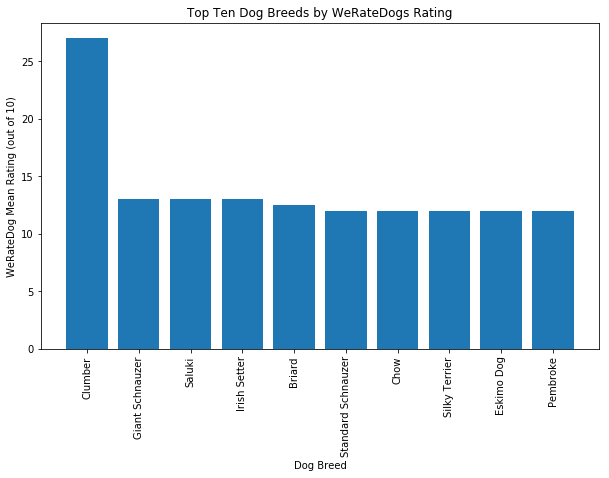

In [629]:
# plotting the mean rating for dog breeds

fig = plt.figure(figsize=(10, 6))
xpos = np.arange(len(df_breed_rating.head(10)))
xticks = df_breed_rating.index

ax = plt.bar(xpos, df_breed_rating.head(10).rating_numerator,width=0.8)
plt.xlabel('Dog Breed')
plt.ylabel('WeRateDog Mean Rating (out of 10)')
plt.xticks(xpos, xticks, rotation=90)
plt.title('Top Ten Dog Breeds by WeRateDogs Rating')
#plt.ylim(top=1e5, bottom=0)
plt.show()

In [628]:
# get the average favorite count for each breed
df_breed_favs = df_master[df_master['p1_dog']==True].groupby(['p1']).mean()\
.sort_values(by=['favorite_count'], ascending=False)

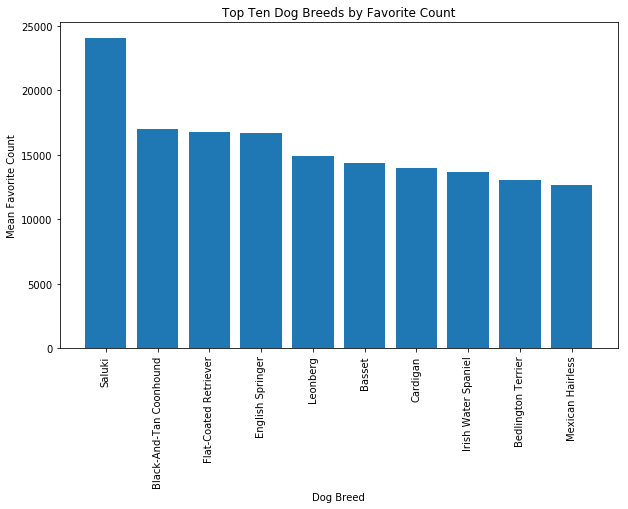

In [653]:
# plotting the mean favorite count for dog breeds

fig = plt.figure(figsize=(10, 6))
xpos = np.arange(len(df_breed_favs.head(10)))
xticks = df_breed_favs.index

ax = plt.bar(xpos, df_breed_favs.head(10).favorite_count,width=0.8)
plt.xlabel('Dog Breed')
plt.ylabel('Mean Favorite Count')
plt.xticks(xpos, xticks, rotation=90)
plt.title('Top Ten Dog Breeds by Favorite Count')
#plt.ylim(top=1e5, bottom=0)
plt.show()

In [668]:
# get the top 20 dog breeds that has both the highest rating and highest favorite count
df_breed_best = pd.merge(df_breed_rating.head(20), df_breed_favs.head(20), how='inner', on=['p1'])\
.sort_values(by=['favorite_count_y'], ascending=False).head(20)

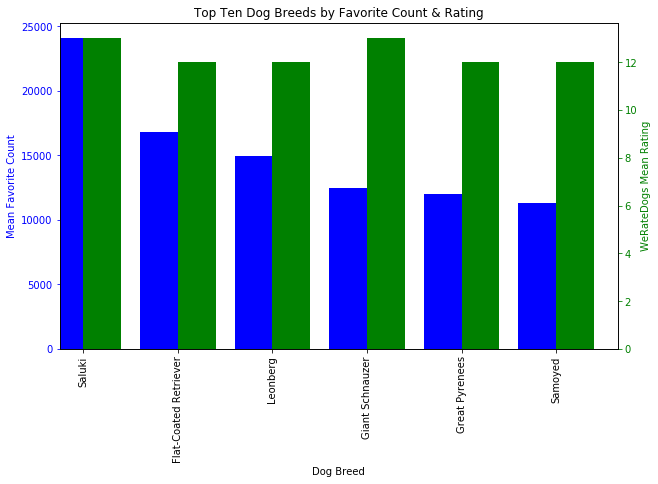

In [669]:
# plot data in two axis style
xpos = np.arange(len(df_breed_best))
xticks = df_breed_best.index

fig = plt.figure(figsize=(10, 6)) # Create matplotlib figure
ax1 = fig.add_subplot(111) # Create matplotlib axes
ax2 = ax1.twinx() # Create another axes that shares the same x-axis as ax.
width = 0.4
d = {'col1':list(df_breed_best.favorite_count_y),'col2':list(df_breed_best.rating_numerator_x)}
y = pd.DataFrame(data=d)
y.col1.plot(kind='bar', color='b', ax=ax1, width=width, position=1)
y.col2.plot(kind='bar', color='g', ax=ax2, width=width, position=0)

ax1.set_ylabel('Mean Favorite Count', color = 'b')
ax1.tick_params('y', colors='b')

ax2.set_ylabel('WeRateDogs Mean Rating', color = 'g')
ax2.tick_params('y', colors='g')

ax1.set_xlabel('Dog Breed')
plt.xticks(xpos, xticks, rotation=90)

plt.title('Top Ten Dog Breeds by Favorite Count & Rating')

plt.show()

### A Look at Tweeting Habits

> Here, we will be looking at when people mostly tweet. It is surprising that Mondays are the days with most tweets and the tweet count drops along the week days and into the weekend. Additionally, November and December are the months with the most tweets. 

>Although these are colder months, they come in the middle of the holidays season which might give the dog owners more time with their pets and hence more chances to take and share cute pictures. This get clear when looking into the individual days of these two months. 

>A surprising rise in tweet count shows towards the end of November and carries into December which supports the idea of having a time-off provides owners with more time to socialize and capture the moments with their dogs.

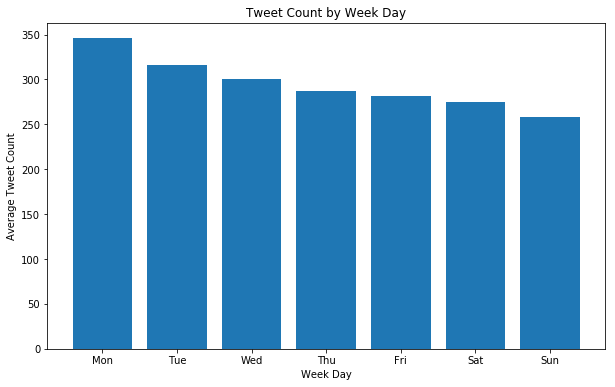

In [683]:
sorter=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
df_tweet_dayofweek = df_master.groupby(['week_day']).count().reindex(sorter)

# plotting the mean favorite count for dog breeds

fig = plt.figure(figsize=(10, 6))
xpos = np.arange(len(df_tweet_dayofweek))
xticks = df_tweet_dayofweek.index

ax = plt.bar(xpos, df_tweet_dayofweek.tweet_id,width=0.8)
plt.xlabel('Week Day')
plt.ylabel('Average Tweet Count')
plt.xticks(xpos, xticks, rotation=0)
plt.title('Tweet Count by Week Day')
#plt.ylim(top=1e5, bottom=0)
plt.show()

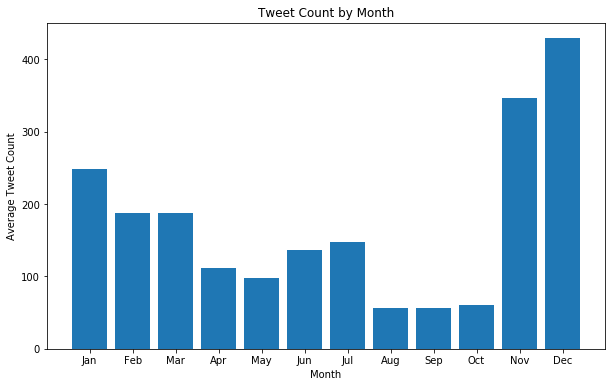

In [681]:
sorter = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
df_tweet_dayofweek = df_master.groupby(['month']).count().reindex(sorter)

# plotting the mean favorite count for dog breeds

fig = plt.figure(figsize=(10, 6))
xpos = np.arange(len(df_tweet_dayofweek))
xticks = df_tweet_dayofweek.index

ax = plt.bar(xpos, df_tweet_dayofweek.tweet_id,width=0.8)
plt.xlabel('Month')
plt.ylabel('Average Tweet Count')
plt.xticks(xpos, xticks, rotation=0)
plt.title('Tweet Count by Month')
#plt.ylim(top=1e5, bottom=0)
plt.show()

<Figure size 432x288 with 0 Axes>

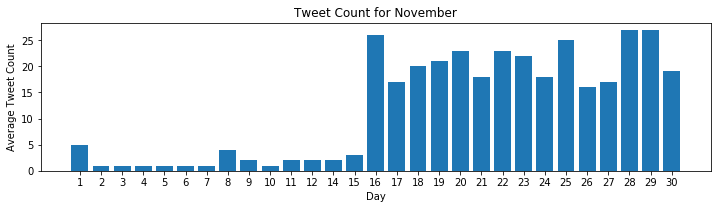

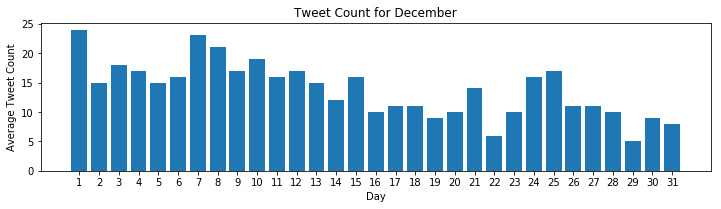

In [684]:
# get the tweet count for each days of November and December
df_tweet_Nov = df_master[df_master['month']=='Nov'].groupby(['day']).count()
df_tweet_Dec = df_master[df_master['month']=='Dec'].groupby(['day']).count()

# plotting the mean tweet count for each day of the two months
plt.figure(1);
fig = plt.figure(figsize=(12, 6));
xpos = np.arange(len(df_tweet_Nov))
xticks = df_tweet_Nov.index.astype(int)

plt.subplot(211);
ax = plt.bar(xpos, df_tweet_Nov.tweet_id,width=0.8)
plt.xlabel('Day')
plt.ylabel('Average Tweet Count')
plt.xticks(xpos, xticks, rotation=0)
plt.title('Tweet Count for November')

plt.figure(2);
fig = plt.figure(figsize=(12, 6));
xpos = np.arange(len(df_tweet_Dec))
xticks = df_tweet_Dec.index.astype(int)

plt.subplot(212);
ax = plt.bar(xpos, df_tweet_Dec.tweet_id,width=0.8)
plt.xlabel('Day')
plt.ylabel('Average Tweet Count')
plt.xticks(xpos, xticks, rotation=0)
plt.title('Tweet Count for December')


plt.show();